In [1]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)
%load_ext autoreload
%autoreload 2

# Deepagent for Research

We will use the `deepagents` package to create a research agent. When using the `deepagents` package, it's important to: 

1. Understand the native tools available
2. Supply task-specific tools
3. Supply task-specific instructions
4. Supply task-specific sub-agents

## Task-Specific Tools 

You can see an overview of the native tools in the [deepagents package README](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#model) as well as the [quickstarts README](https://github.com/langchain-ai/deepagents-quickstarts). We'll extend this with two task-specific tools. 

### Search Tool 

There are different search tools that we can use. For example, we can use [Tavily](https://www.tavily.com/) to search for relevant URLs, then fetches the full webpage content.

### Think Tool 

We'll supply a [think tool](https://www.anthropic.com/engineering/claude-think-tool), which is a useful way to help audit agent decision making. 

In [3]:
from research_agent.tools import tavily_search, think_tool
tools = [tavily_search, think_tool]

## Task-Specific Instructions
 
Next, let's define task specific instructions using [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

In [4]:
from datetime import datetime
from utils import show_prompt, format_messages
from research_agent.prompts import (
    RESEARCHER_INSTRUCTIONS,
    RESEARCH_WORKFLOW_INSTRUCTIONS,
    SUBAGENT_DELEGATION_INSTRUCTIONS,
)

In [5]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the research tools provided to you to find resources that can help answer the research      │
│  question.                                                                                                      │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Research Tools>                                                                                     │
│  You have access to two specific research tools:                                                                │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Research Tools>                                                                                    │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

## Task-Specific Sub-Agents

You can specify [custom subagents](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#subagents) as a means of context isolation. 

Here's well define a sub-agent that can search the web for information. 

In [6]:
# Get current date
current_date = datetime.now().strftime("%Y-%m-%d")

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS.format(date=current_date),
    "tools": [tavily_search, think_tool],
}

## Putting it all together

### Instructions

Now, we can look at all of our instructions together. 

In [7]:
# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Combine orchestrator instructions (RESEARCHER_INSTRUCTIONS only for sub-agents)
INSTRUCTIONS = (
    RESEARCH_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    +  SUBAGENT_DELEGATION_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
    )
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Research Workflow                                                                                            │
│                                                                                                                 │
│  Follow this workflow for all research requests:                                                                │
│                                                                                                                 │
│  1. **Plan**: Create a todo list with write_todos to break down the research into focused tasks                 │
│  2. **Save the request**: Use write_file() to save the user's research question to `/research_request.md`       │
│  3. **Research**: Delegate research tasks to sub-agents using the task() tool - ALWAYS use sub-agents for       │
│  research, never conduct research yourself                                                                      │
│  4. **Synthesize**: Review all sub-agent findings and consolidate citations (each unique URL gets one number    │
│  across all findings)                                                                                           │
│  5. **Write Report**: Write a comprehensive final report to `/final_report.md` (see Report Writing Guidelines   │
│  below)                                                                                                         │
│  6. **Verify**: Read `/research_request.md` and confirm you've addressed all aspects with proper citations and  │
│  structure                                                                                                      │
│                                                                                                                 │
│  ## Research Planning Guidelines                                                                                │
│  - Batch similar research tasks into a single TODO to minimize overhead                                         │
│  - For simple fact-finding questions, use 1 sub-agent                                                           │
│  - For comparisons or multi-faceted topics, delegate to multiple parallel sub-agents                            │
│  - Each sub-agent should research one specific aspect and return findings                                       │
│                                                                                                                 │
│  ## Report Writing Guidelines                                                                                   │
│                                                                                                                 │
│  When writing the final report to `/final_report.md`, follow these structure patterns:                          │
│                                                                                                                 │
│  **For comparisons:**                                                                                           │
│  1. Introduction                                                                                                │
│  2. Overview of topic A                                                                                         │
│  3. Overview of topic B                                                                                         │
│  4. Detailed comparison                                                                                         │
│  5. Conclusion                                                                                                  │
│                                                                                                                 │
│  **For lists/rankings:**                              

### Create the agent

Now, we create our deepagent with these components. 

In [10]:
import os 
from IPython.display import Image, display
from deepagents import create_deep_agent
from langchain_openai import ChatOpenAI
from pydantic import SecretStr

# Model Claude 4.5
# model = init_chat_model(model="anthropic:claude-sonnet-4-5-20250929", temperature=0.0)

# use openrouter for cheap, efficient models
model = ChatOpenAI(
    model="x-ai/grok-4.1-fast", 
    
    # redirect LangChain to OpenRouter
    base_url="https://openrouter.ai/api/v1",

    # pass the OpenRouter key
    api_key=SecretStr(os.environ["OPENROUTER_API_KEY"])
)

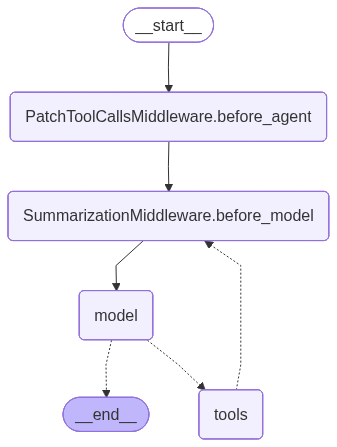

In [11]:
# Create the agent
agent = create_deep_agent(
      model=model,
      tools=tools, 
      system_prompt=INSTRUCTIONS,
      subagents=[research_sub_agent],
  )
  
# Show the agent
display(Image(agent.get_graph().draw_mermaid_png()))

In [12]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "research context engineering approaches used to build AI agents",
            }
        ],
    }, 
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ research context engineering approaches used to build AI agents                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/research_request.md",                                                                          │
│   "content": "research context engineering approaches used to build AI agents"                                  │
│ }                                                                                                               │
│    ID: call_67586407                                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the user's research request to /research_request.md",                                    │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research task to sub-agent(s): Research context engineering approaches used to build │
│ AI agents, including definitions, key techniques, examples, tools, best practices, and relevant sources.",      │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize sub-agent findings, consolidate unique citations (assign sequential numbers to     │
│ unique URLs across all findings).",                                                                             │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comprehensive final report to /final_report.md following Report Writing Guidelines (use │
│ overview structure: Overview, Key concepts/techniques, Examples, Best practices, Conclusion; inline citations   │
│ [1], end with ### Sources).",                                                                                   │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify: Read /research_request.md and /

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /research_request.md                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': "Save the user's research request to /research_request.md", 'status':         │
│ 'completed'}, {'content': 'Delegate research task to sub-agent(s): Research context engineering approaches used │
│ to build AI agents, including definitions, key techniques, examples, tools, best practices, and relevant        │
│ sources.', 'status': 'in_progress'}, {'content': 'Synthesize sub-agent findings, consolidate unique citations   │
│ (assign sequential numbers to unique URLs across all findings).', 'status': 'pending'}, {'content': 'Write      │
│ comprehensive final report to /final_report.md following Report Writing Guidelines (use overview structure:     │
│ Overview, Key concepts/techniques, Examples, Best practices, Conclusion; inline citations [1], end with ###     │
│ Sources).', 'status': 'pending'}, {'content': 'Verify: Read /research_request.md and /final_report.md to        │
│ confirm all aspects addressed with proper structure and citations.', 'status': 'pending'}]                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ## Overview                                                                                                     │
│                                                                                                                 │
│ Context engineering in AI agents refers to the deliberate design, construction, and management of the           │
│ information environment provided to large language models (LLMs), ensuring the right information, structure,    │
│ and timing for reliable task performance [2][3]. It extends beyond prompt engineering by orchestrating          │
│ instructional context (prompts, system messages), knowledge context (facts, memories), and tool context (APIs,  │
│ searches) within the model's limited context window, akin to curating RAM for an operating system [3]. This     │
│ iterative process enhances agent reliability, reduces hallucinations, and supports complex workflows like       │
│ multi-turn reasoning and tool use [1].                                                                          │
│                                                                                                                 │
│ ## Key Approaches                                                                                               │
│                                                                                                                 │
│ Key techniques include:                                                                                         │
│                                                                                                                 │
│ - **Prompt Engineering Variants**: High-level role definitions, explicit general instructions, essential        │
│ context (e.g., current date), and detailed tool usage guidelines in system prompts to guide agent behavior [1]. │
│ Meta-prompting and structured templates encode domain logic [2].                                                │
│                                                                                                                 │
│ - **Memory Systems**: Short-term scratchpads for intermediate notes/plans; long-term memories (semantic for     │
│ facts, episodic for experiences, procedural for instructions) stored externally in databases or vector stores   │
│ for retrieval [3].                                                                                              │
│                                                                                                                 │
│ - **Retrieval Methods**: Retrieval-Augmented Generation (RAG) for selecting relevant snippets from knowledge    │
│ bases, embeddings, or graphs; re-ranking and filtering to prioritize pertinence and avoid overload [3].         │
│                                                                                                                 │
│ - **Tool Integration**: Detailed tool descriptions with usage instructions; sandboxed execution to isolate      │
│ outputs; multi-agent handoffs with summarized results [1][3].                                                   │
│                                                                                                                 │
│ - **State Management**: Compression via summarization (hierarchical distillation of conversations/tools) and    │
│ trimming (heuristic removal of stale data); isolation through compartmentalized workflows, state objects, and   │
│ sub-agents with partial contexts [3].                                                                           │
│                                                                                                                 │
│ ## Examples                                                                                                     │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the user's research request to /research_request.md",                                    │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research task to sub-agent(s): Research context engineering approaches used to build │
│ AI agents, including definitions, key techniques, examples, tools, best practices, and relevant sources.",      │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize sub-agent findings, consolidate unique citations (assign sequential numbers to     │
│ unique URLs across all findings).",                                                                             │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comprehensive final report to /final_report.md following Report Writing Guidelines (use │
│ overview structure: Overview, Key concepts/techniques, Examples, Best practices, Conclusion; inline citations   │
│ [1], end with ### Sources).",                                                                                   │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify: Read /research_request.md and /final_report.md to confirm all aspects addressed with  │
│ proper structure and citations.",                                                                               │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_65174925                                                                                            │
│                                                         

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': "Save the user's research request to /research_request.md", 'status':         │
│ 'completed'}, {'content': 'Delegate research task to sub-agent(s): Research context engineering approaches used │
│ to build AI agents, including definitions, key techniques, examples, tools, best practices, and relevant        │
│ sources.', 'status': 'completed'}, {'content': 'Synthesize sub-agent findings, consolidate unique citations     │
│ (assign sequential numbers to unique URLs across all findings).', 'status': 'completed'}, {'content': 'Write    │
│ comprehensive final report to /final_report.md following Report Writing Guidelines (use overview structure:     │
│ Overview, Key concepts/techniques, Examples, Best practices, Conclusion; inline citations [1], end with ###     │
│ Sources).', 'status': 'in_progress'}, {'content': 'Verify: Read /research_request.md and /final_report.md to    │
│ confirm all aspects addressed with proper structure and citations.', 'status': 'pending'}]                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /final_report.md                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/research_request.md"                                                                           │
│ }                                                                                                               │
│    ID: call_70334540                                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/final_report.md"                                                                               │
│ }                                                                                                               │
│    ID: call_23559053                                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the user's research request to /research_request.md",                                    │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research task to sub-agent(s): Research context engineering approaches used to build │
│ AI agents, including definitions, key techniques, examples, tools, best practices, and relevant sources.",      │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize sub-agent findings, consolidate unique citations (assign sequential numbers to     │
│ unique URLs across all findings).",                                                                             │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comprehensive final report to /final_report.md following Report Writing Guidelines (use │
│ overview structure: Overview, Key concepts/techniques, Exa

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  research context engineering approaches used to build AI agents                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  ## Overview                                                                                             │
│      2                                                                                                          │
│      3  Context engineering in AI agents involves the deliberate design, construction, and management of the    │
│ information environment supplied to large language models (LLMs). This process ensures that the appropriate     │
│ information, structure, and timing are provided within the model's limited context window to enable reliable    │
│ task performance. It extends traditional prompt engineering by orchestrating instructional context—such as      │
│ prompts and system messages—knowledge context including facts and memories, and tool context like APIs and      │
│ searches. This approach is likened to curating RAM for an operating system, enhancing agent reliability,        │
│ reducing hallucinations, and supporting complex workflows involving multi-turn reasoning and tool usage         │
│ [1][2][3].                                                                                                      │
│      4                                                                                                          │
│      5  ## Key Concepts and Techniques                                                                          │
│      6                                                                                                          │
│      7  Several core techniques underpin context engineering. Prompt engineering variants emphasize high-level  │
│ role definitions, explicit general instructions, essential contextual details like the current date, and        │
│ detailed guidelines for tool usage within system prompts to guide agent behavior. Advanced methods include      │
│ meta-prompting and structured templates that encode domain-specific logic [1][2].                               │
│      8                                                                                                          │
│      9  Memory systems play a crucial role, featuring short-term scratchpads for intermediate notes and plans,  │
│ alongside long-term memories categorized as semantic for facts, episodic for experiences, and procedural for    │
│ instructions. These are typically stored externally in databases or vector stores and retrieved as needed [3].  │
│     10                                                                                                          │
│     11  Retrieval methods, such as Retrieval-Augmented Generation (RAG), select relevant snippets from          │
│ knowledge bases, embeddings, or graphs, often incorporating re-ranking and filtering to ensure pertinence and   │
│ prevent context overload [3].                                                                                   │
│     12                                                                                                          │
│     13  Tool integration requires detailed descriptions of tools along with usage instructions, sandboxed       │
│ execution to isolate outputs, and multi-agent handoffs that summarize results for efficiency [1][3].            │
│     14                                                                                                          │
│     15  State management addresses context limitations through compression techniques like summarization—via    │
│ hierarchical distillation of conversations and tool outputs—and trimming, which uses heuristics to remove stale │
│ data. Isolation is achieved through compartmentalized workflows, state objects, and sub-agents operating with   │
│ partial contexts [3].                                                                                           │
│     16                                                 

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': "Save the user's research request to /research_request.md", 'status':         │
│ 'completed'}, {'content': 'Delegate research task to sub-agent(s): Research context engineering approaches used │
│ to build AI agents, including definitions, key techniques, examples, tools, best practices, and relevant        │
│ sources.', 'status': 'completed'}, {'content': 'Synthesize sub-agent findings, consolidate unique citations     │
│ (assign sequential numbers to unique URLs across all findings).', 'status': 'completed'}, {'content': 'Write    │
│ comprehensive final report to /final_report.md following Report Writing Guidelines (use overview structure:     │
│ Overview, Key concepts/techniques, Examples, Best practices, Conclusion; inline citations [1], end with ###     │
│ Sources).', 'status': 'completed'}, {'content': 'Verify: Read /research_request.md and /final_report.md to      │
│ confirm all aspects addressed with proper structure and citations.', 'status': 'in_progress'}]                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the user's research request to /research_request.md",                                    │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research task to sub-agent(s): Research context engineering approaches used to build │
│ AI agents, including definitions, key techniques, examples, tools, best practices, and relevant sources.",      │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize sub-agent findings, consolidate unique citations (assign sequential numbers to     │
│ unique URLs across all findings).",                                                                             │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comprehensive final report to /final_report.md following Report Writing Guidelines (use │
│ overview structure: Overview, Key concepts/techniques, Examples, Best practices, Conclusion; inline citations   │
│ [1], end with ### Sources).",                                                                                   │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify: Read /research_request.md and /final_report.md to confirm all aspects addressed with  │
│ proper structure and citations.",                                                                               │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_97635721                                                                                            │
╰─────────────────────────────────────────────────────────

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': "Save the user's research request to /research_request.md", 'status':         │
│ 'completed'}, {'content': 'Delegate research task to sub-agent(s): Research context engineering approaches used │
│ to build AI agents, including definitions, key techniques, examples, tools, best practices, and relevant        │
│ sources.', 'status': 'completed'}, {'content': 'Synthesize sub-agent findings, consolidate unique citations     │
│ (assign sequential numbers to unique URLs across all findings).', 'status': 'completed'}, {'content': 'Write    │
│ comprehensive final report to /final_report.md following Report Writing Guidelines (use overview structure:     │
│ Overview, Key concepts/techniques, Examples, Best practices, Conclusion; inline citations [1], end with ###     │
│ Sources).', 'status': 'completed'}, {'content': 'Verify: Read /research_request.md and /final_report.md to      │
│ confirm all aspects addressed with proper structure and citations.', 'status': 'completed'}]                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ## Overview                                                                                                     │
│                                                                                                                 │
│ Context engineering in AI agents involves the deliberate design, construction, and management of the            │
│ information environment supplied to large language models (LLMs). This process ensures that the appropriate     │
│ information, structure, and timing are provided within the model's limited context window to enable reliable    │
│ task performance. It extends traditional prompt engineering by orchestrating instructional context—such as      │
│ prompts and system messages—knowledge context including facts and memories, and tool context like APIs and      │
│ searches. This approach is likened to curating RAM for an operating system, enhancing agent reliability,        │
│ reducing hallucinations, and supporting complex workflows involving multi-turn reasoning and tool usage         │
│ [1][2][3].                                                                                                      │
│                                                                                                                 │
│ ## Key Concepts and Techniques                                                                                  │
│                                                                                                                 │
│ Several core techniques underpin context engineering. Prompt engineering variants emphasize high-level role     │
│ definitions, explicit general instructions, essential contextual details like the current date, and detailed    │
│ guidelines for tool usage within system prompts to guide agent behavior. Advanced methods include               │
│ meta-prompting and structured templates that encode domain-specific logic [1][2].                               │
│                                                                                                                 │
│ Memory systems play a crucial role, featuring short-term scratchpads for intermediate notes and plans,          │
│ alongside long-term memories categorized as semantic for facts, episodic for experiences, and procedural for    │
│ instructions. These are typically stored externally in databases or vector stores and retrieved as needed [3].  │
│                                                                                                                 │
│ Retrieval methods, such as Retrieval-Augmented Generation (RAG), select relevant snippets from knowledge bases, │
│ embeddings, or graphs, often incorporating re-ranking and filtering to ensure pertinence and prevent context    │
│ overload [3].                                                                                                   │
│                                                                                                                 │
│ Tool integration requires detailed descriptions of tools along with usage instructions, sandboxed execution to  │
│ isolate outputs, and multi-agent handoffs that summarize results for efficiency [1][3].                         │
│                                                                                                                 │
│ State management addresses context limitations through compression techniques like summarization—via            │
│ hierarchical distillation of conversations and tool outputs—and trimming, which uses heuristics to remove stale │
│ data. Isolation is achieved through compartmentalized workflows, state objects, and sub-agents operating with   │
│ partial contexts [3].                                                                                           │
│                                                        

In [13]:
from deepagents.backends.utils import file_data_to_string

# Convert a specific file to string
file_content = file_data_to_string(result["files"]['/final_report.md'])
show_prompt(file_content) 

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  ## Overview                                                                                                    │
│                                                                                                                 │
│  Context engineering in AI agents involves the deliberate design, construction, and management of the           │
│  information environment supplied to large language models (LLMs). This process ensures that the appropriate    │
│  information, structure, and timing are provided within the model's limited context window to enable reliable   │
│  task performance. It extends traditional prompt engineering by orchestrating instructional context—such as     │
│  prompts and system messages—knowledge context including facts and memories, and tool context like APIs and     │
│  searches. This approach is likened to curating RAM for an operating system, enhancing agent reliability,       │
│  reducing hallucinations, and supporting complex workflows involving multi-turn reasoning and tool usage        │
│  [1][2][3].                                                                                                     │
│                                                                                                                 │
│  ## Key Concepts and Techniques                                                                                 │
│                                                                                                                 │
│  Several core techniques underpin context engineering. Prompt engineering variants emphasize high-level role    │
│  definitions, explicit general instructions, essential contextual details like the current date, and detailed   │
│  guidelines for tool usage within system prompts to guide agent behavior. Advanced methods include              │
│  meta-prompting and structured templates that encode domain-specific logic [1][2].                              │
│                                                                                                                 │
│  Memory systems play a crucial role, featuring short-term scratchpads for intermediate notes and plans,         │
│  alongside long-term memories categorized as semantic for facts, episodic for experiences, and procedural for   │
│  instructions. These are typically stored externally in databases or vector stores and retrieved as needed      │
│  [3].                                                                                                           │
│                                                                                                                 │
│  Retrieval methods, such as Retrieval-Augmented Generation (RAG), select relevant snippets from knowledge       │
│  bases, embeddings, or graphs, often incorporating re-ranking and filtering to ensure pertinence and prevent    │
│  context overload [3].                                                                                          │
│                                                                                                                 │
│  Tool integration requires detailed descriptions of tools along with usage instructions, sandboxed execution    │
│  to isolate outputs, and multi-agent handoffs that summarize results for efficiency [1][3].                     │
│                                                                                                                 │
│  State management addresses context limitations through compression techniques like summarization—via           │
│  hierarchical distillation of conversations and tool outputs—and trimming, which uses heuristics to remove      │
│  stale data. Isolation is achieved through compartment

Trace: 

https://smith.langchain.com/public/95c987db-1bb3-47ef-b5a7-3d079cbce566/r